In [1]:
from typing import Tuple

import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
from dtw import dtw
from tqdm.notebook import tqdm
import seaborn as sns

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



### Getting FFT matches

In [2]:
df_matches = pd.read_csv("../data/df_ucr_min_delta.csv")

In [5]:
df_matches.head()

ts_1  no_1  class_1   ts_2  no_2  class_2     type  match_score min_kpi  \
0  ACSF1     0        9  ACSF1     0        0  Hamming        11111     d_m   
1  ACSF1     0        9  ACSF1    35       35  Hamming        11111  d_mean   
2  ACSF1     0        9  ACSF1    22       22  Hamming        11111   d_std   
3  ACSF1     0        9  ACSF1     8        8  Hamming        11111   d_q25   
4  ACSF1     0        9  ACSF1     8        8  Hamming        11111   d_q50   

          value  
0  0.000000e+00  
1  3.767138e-11  
2  5.256329e-10  
3  3.545120e-03  
4  3.483790e-03

### Getting DTW matches

In [3]:
df_dtw = pd.read_csv("../data/df_dtw_comp.csv")

In [4]:
df_dtw.head()

ts_1  no_1  class_1                 ts_2  no_2  class_2  \
0            ArrowHead   153        2            ArrowHead     8        2   
1            ArrowHead   154        2            ArrowHead    17        2   
2  InsectWingbeatSound    98        8  InsectWingbeatSound   175        7   
3  InsectWingbeatSound   174        5  InsectWingbeatSound   170        9   
4  InsectWingbeatSound   194        4  InsectWingbeatSound    61        4   

   min_dtw_dist  
0     11.453478  
1      7.934686  
2     24.418690  
3     32.303582  
4     16.177841

In [6]:
df_dtw[df_dtw['no_1']==12221]

ts_1   no_1  class_1  ts_2  no_2  class_2  min_dtw_dist
688  Crop  12221       18  Crop  5324       18       0.50483

### Loading UCR data

In [2]:
ts_train_infos = []
ts_test_infos = []
for root, dirs, files in os.walk("../data/ucr_data/UCRArchive_2018/"):
    for name in files:
        if(name.endswith("_TRAIN.tsv")):
            path_tmp = os.path.join(root,name)
            ts_name = re.split("/", root)[-1]
            ts_train_infos.append((ts_name, os.path.join(root,name)))
        elif(name.endswith("_TEST.tsv")):
            path_tmp = os.path.join(root,name)
            ts_name = re.split("/", root)[-1]
            ts_test_infos.append((ts_name, os.path.join(root,name)))
            

In [1]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

for ts_info in tqdm(ts_train_infos):
    ts_name = ts_info[0]
    fp = ts_info[1]
    
    df_tmp = pd.read_csv(fp, sep='\t', header=None)
    df_tmp['name'] = ts_name
    df_tmp['no'] = df_tmp.index
    cols = df_tmp.columns.tolist()
    cols = cols[-2:] + cols[:-2]
    df_tmp = df_tmp[cols]
    df_train = df_train.append(df_tmp)
    
for ts_info in tqdm(ts_test_infos):
    ts_name = ts_info[0]
    fp = ts_info[1]
    
    df_tmp = pd.read_csv(fp, sep='\t', header=None)
    df_tmp['name'] = ts_name
    df_tmp['no'] = df_tmp.index
    cols = df_tmp.columns.tolist()
    cols = cols[-2:] + cols[:-2]
    df_tmp = df_tmp[cols]
    df_test = df_test.append(df_tmp)
    
# df_train = df_train.reset_index().rename(columns={'index': 'no'})
# df_test = df_test.reset_index().rename(columns={'index': 'no'})
print("df_train shape: {}".format(df_train.shape))
print("df_test shape: {}".format(df_test.shape))

NameError: name 'pd' is not defined

In [4]:
df_train.head()

name  no  0         1         2         3         4         5         6  \
0  Haptics   0  5 -1.047477  0.548336 -0.259562 -1.581216 -1.915218 -1.278188   
1  Haptics   1  2 -1.018153  0.514133 -0.097370 -1.374493 -1.957364 -1.567188   
2  Haptics   2  4 -1.183382  0.339636  0.045998 -1.080209 -1.934357 -1.972025   
3  Haptics   3  3 -0.896969  0.186145  0.578290  0.392361 -0.157240 -0.818047   
4  Haptics   4  5 -1.009424  0.614673 -0.397552 -1.766144 -1.906942 -1.145026   

          7  ...  2835  2836  2837  2838  2839  2840  2841  2842  2843  2844  
0 -0.691525  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1 -0.906353  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2 -1.412721  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3 -1.374046  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4 -0.717200  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 2847 columns]

In [58]:
y = np.array(df_train[(df_train['name']=="FordA")][0])[:1000]
n = y.shape[0]
# ar_wiiY = np.array(df_test[(df_test['name']=="AllGestureWiimoteY")].iloc[1,3:].dropna())[0]
# ar_wiiZ = np.array(df_test[(df_test['name']=="AllGestureWiimoteZ")].iloc[1,3:].dropna())[0]
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(15,10))
x = np.linspace(1,n,n)
sns.lineplot(x=x,y=y, label="Engine Noise Pattern", ax=ax)
fig.savefig("../img/ford_engine_noise.png")

### Plotting results

### Matches in FFT

Template series

UCR FFT Matches

In [20]:
def get_dtw_match(ts_name: str,
                  ts_no: int) -> Tuple[str, int,np.ndarray]:
    """ return matching series via DTW """
    s_tmp = df_dtw[(df_dtw['ts_1']==ts_name)&
           (df_dtw['no_1']==ts_no)].squeeze()
    print(f"s_tmp: {type(s_tmp['ts_2'])}")
    ar = np.array(df_train[(df_train['name']==s_tmp['ts_2'])&
             (df_train['no']==s_tmp['no_2'])].iloc[:1,3:].dropna(axis=1))[0]
    return s_tmp['ts_2'], s_tmp['no_2'], ar
    

In [64]:
def random_results_comparison(ts_name, ts_no)->None:
    if (ts_name == None) & (ts_no == None):
        sample_idx = df_matches.set_index(['ts_1','no_1']).sample().index[0]
        ts_name = sample_idx[0]
        ts_no = sample_idx[1]
    print(ts_name)
    print(ts_no)


    df_tmp = df_matches[(df_matches['ts_1']==ts_name) &
              (df_matches['no_1']==ts_no)]

    kpis = list(df_tmp['min_kpi'].unique())

    ar_tmpl = np.array(df_test[(df_test['name']==ts_name) &
                          (df_test['no']==ts_no)].iloc[:,3:].dropna(axis=1))[0]

    dtw_name, dtw_no, dtw_ar = get_dtw_match(ts_name, ts_no)


    fig, axs = plt.subplots(4,2, figsize=(15,10))
    fig.tight_layout()

    # plots
    for i in range(8):
        axs.flatten()[i].plot(ar_tmpl, label="Templ: {} - {}".format(ts_name, ts_no))
        axs.flatten()[i].plot(dtw_ar, label="DTW: {} - {}".format(dtw_name, dtw_no))
        kpi = kpis[i] 
        axs.flatten()[i].set_title("{} - match".format(kpi))

        # get winner for particular KPI

        df_min = df_tmp[(df_tmp['ts_1']==ts_name) &
                (df_tmp['no_1']==ts_no) &
                (df_tmp['min_kpi']==kpi)]\
        .sort_values(['match_score','value'], ascending=[False,True])
        # take first entry as it is the lowest

        s_min = df_min.iloc[0,:].squeeze()
        name_tmp = s_min['ts_2']
        no_tmp = s_min['no_2']
        f_type = s_min['type']

        ar_min = np.array(df_train[(df_train['name']==name_tmp)&
           (df_train['no']==no_tmp)].iloc[:,3:].dropna(axis=1))[0]

        axs.flatten()[i].plot(ar_min, label="{}: {} - {}".format(f_type, name_tmp, no_tmp))
        axs.flatten()[i].legend()


    fig.savefig("../img/dtw_fft_comp/{}_{}.png".format(ts_name,ts_no))

Wafer
5710
s_tmp: <class 'str'>


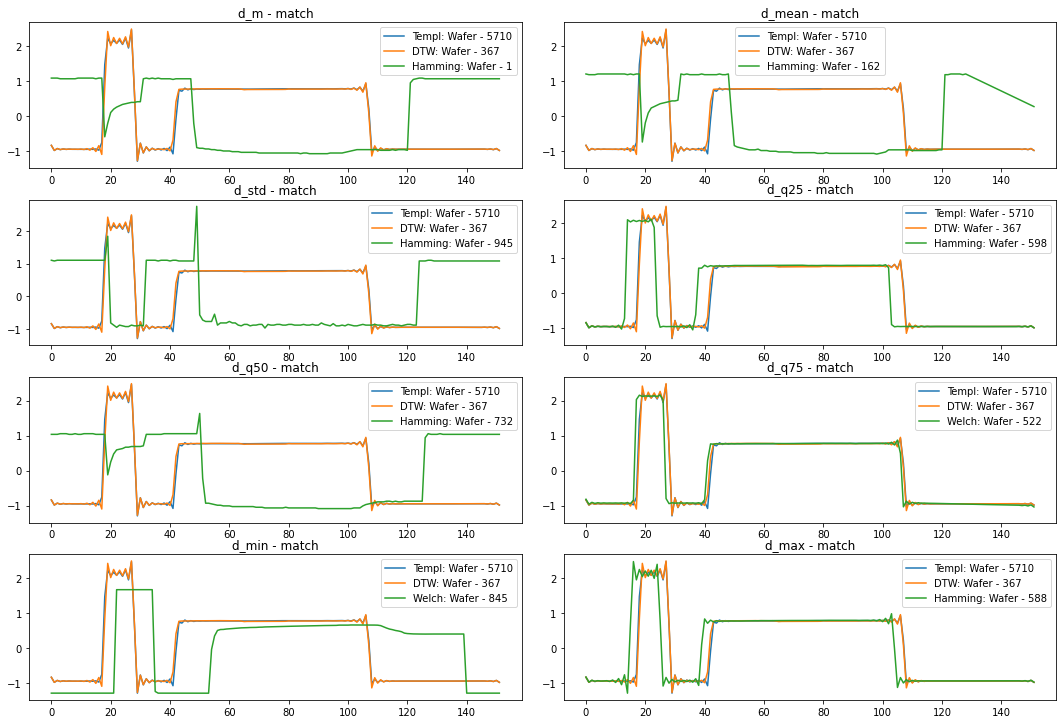

In [87]:
random_results_comparison('Wafer', 5710)

WordSynonyms
224
s_tmp: <class 'str'>
Rock
19
s_tmp: <class 'str'>
Worms
14
s_tmp: <class 'str'>
Earthquakes
20
s_tmp: <class 'str'>
PigAirwayPressure
140
s_tmp: <class 'str'>
Car
55
s_tmp: <class 'str'>
SyntheticControl
102
s_tmp: <class 'str'>
DiatomSizeReduction
105
s_tmp: <class 'str'>
DistalPhalanxOutlineAgeGroup
136
s_tmp: <class 'str'>
MiddlePhalanxOutlineCorrect
206
s_tmp: <class 'str'>
Rock
46
s_tmp: <class 'str'>
GunPoint
143
s_tmp: <class 'str'>
PigCVP
2
s_tmp: <class 'str'>
GestureMidAirD2
105
s_tmp: <class 'pandas.core.series.Series'>


ValueError: Can only compare identically-labeled Series objects

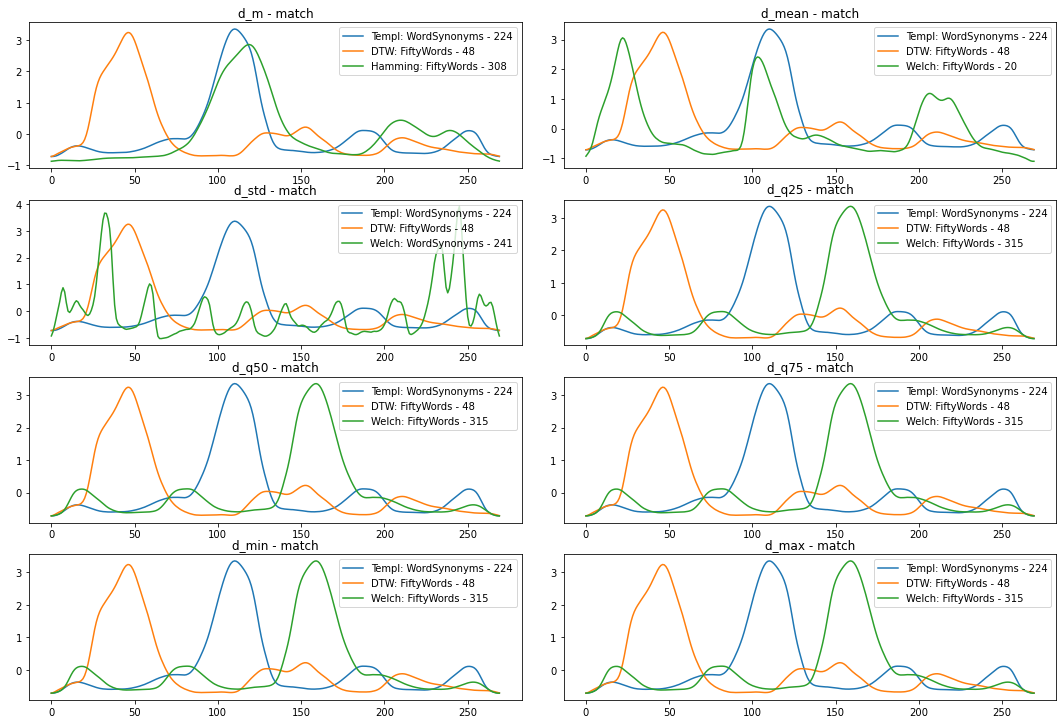

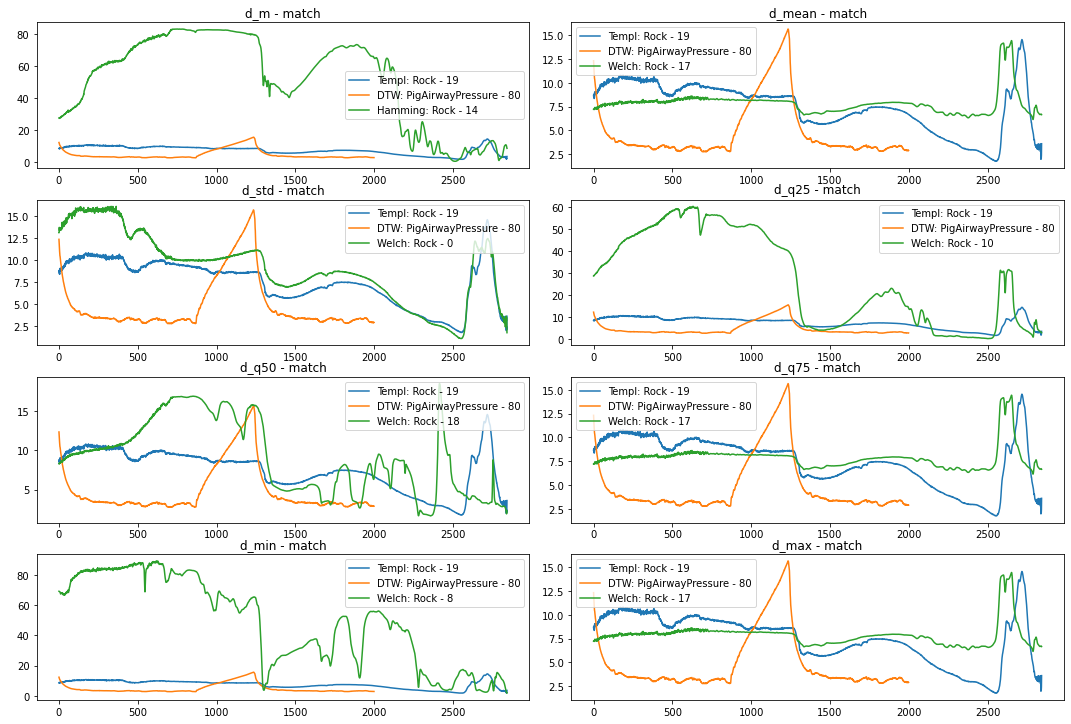

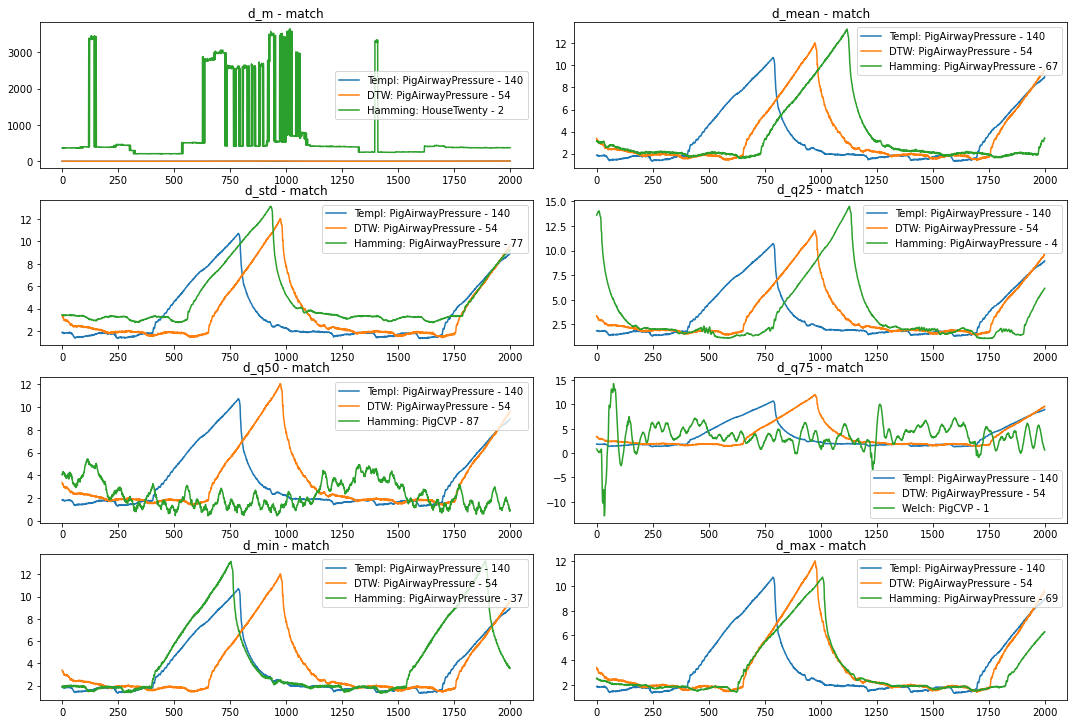

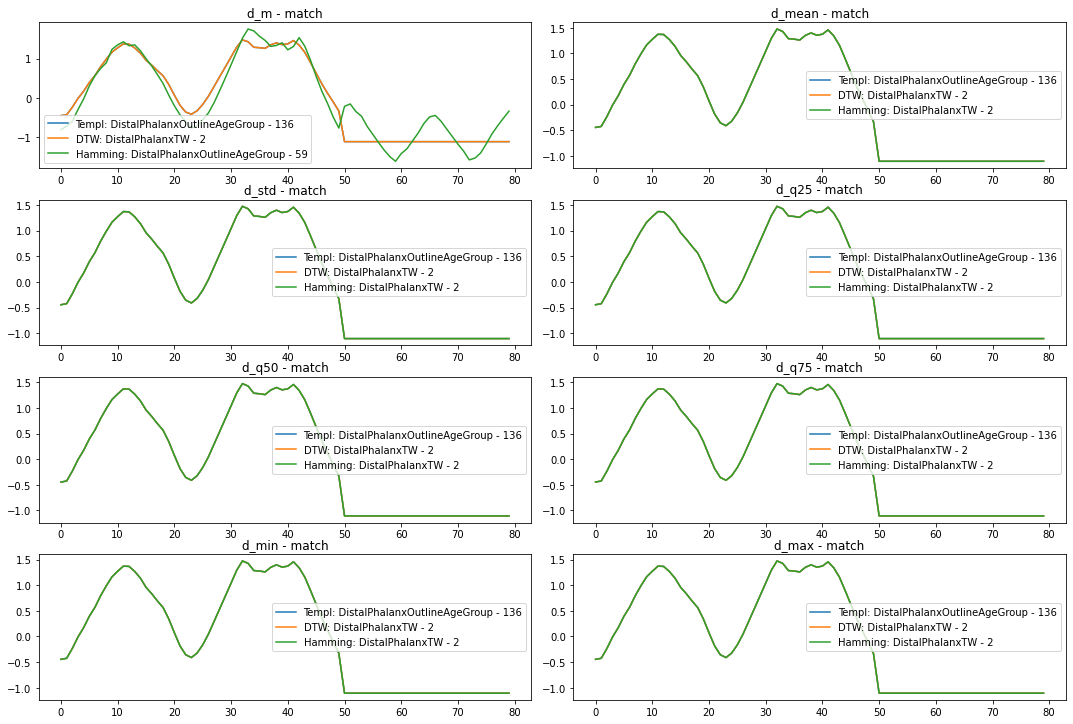

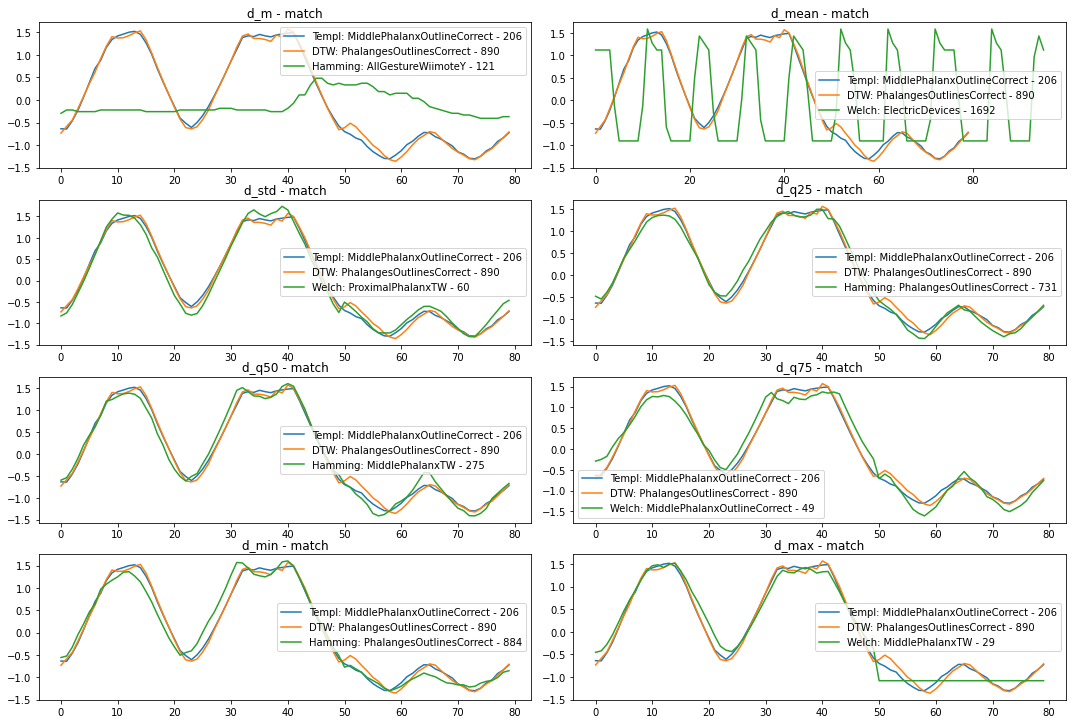

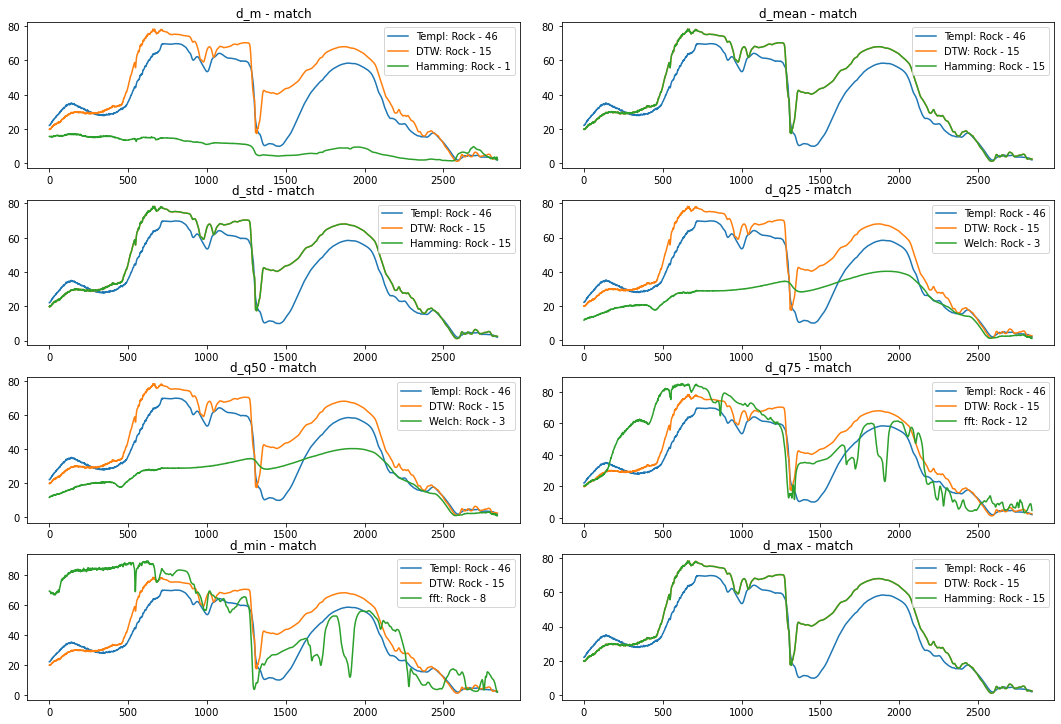

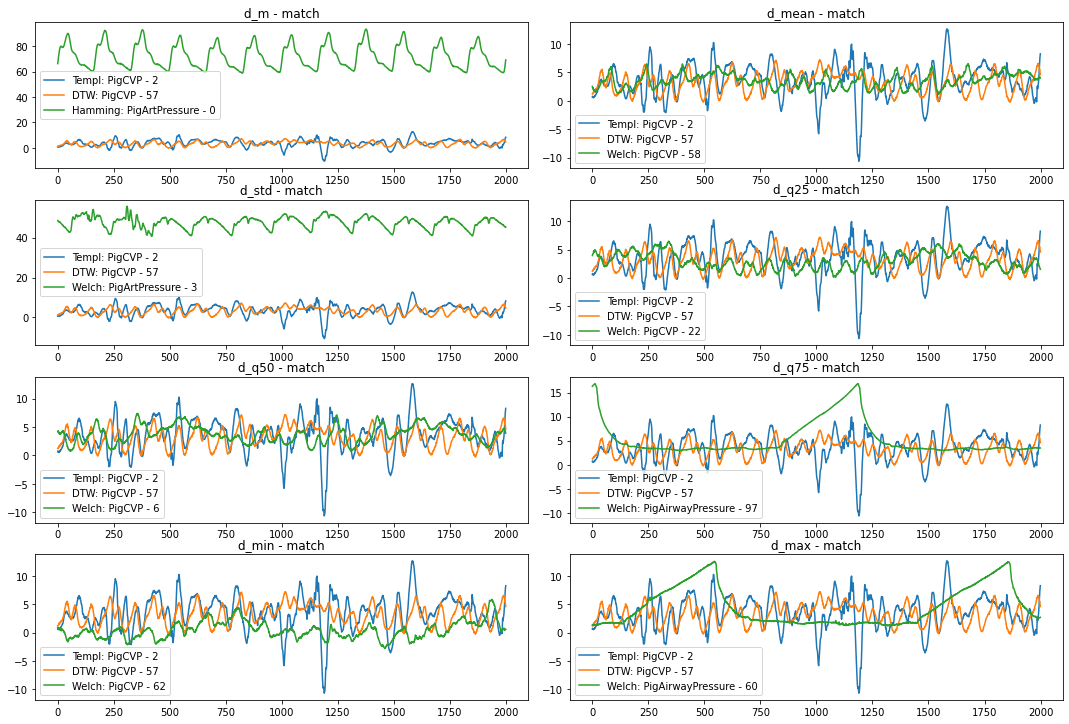

In [21]:
for i in range(30):
    random_results_comparison()

### Remember df_test

PigAirwayPressure 124

ToeSegmentation1 202

SonyAIBORobotSurface2 612

SmoothSubspace 126

InsectWingbeatSound 1662

PigAirwayPressure

ProximalPhalanxOutlineCorrect - 273

FFT Failure: FaceFour 66

Haptics - 266

Phoneme - 1787

FordB - 590

FFT bad: EOGHorizontalSignal - 215

good example: FaceFour - 51

FFT advantage through closeness of spikes: LargeKitchenAppliances - 0

Sin/Cos at work: Mallat - 1506

case for building ranges/thresholds: FreezerSmallTrain - 1430

further fine-tuning of parameters for selection required: PowerCons - 81

Ham 56

ECGFiveDays 495

issue with magnitude: BME 86

FreezerRegularTrain 278

CricketZ 222

In [229]:
AllGestureWiimoteZ
203

NameError: name 'AllGestureWiimoteZ' is not defined

In [24]:
df_r = pd.read_csv("../data/ucr_data/UCRArchive_2018/Rock/Rock_TEST.tsv", sep="\t")

In [51]:
df_d = pd.read_csv("../data/ucr_data/UCRArchive_2018/PigAirwayPressure/PigAirwayPressure_TRAIN.tsv", sep="\t")

In [42]:
df_d.head()

1  1.950073  1.913452  1.8737791  1.882935  1.849365  1.864624  1.828003  \
0  1  1.284790  1.290894   1.290894  1.223755  1.205444  1.205444  1.184082   
1  1  1.208496  1.181030   1.196289  1.208496  1.181030  1.196289  1.229858   
2  1  1.831055  1.852417   1.794434  1.828003  1.852417  1.803589  1.849365   
3  2  0.009155  0.018311  -0.006104 -0.009155  0.018311  0.009155  0.036621   
4  2  0.021362  0.045776   0.003052 -0.012207  0.021362  0.018311  0.003052   

   1.809692  1.8218991  ...     1.5625  1.516724.5  1.513672.4  1.480103.1  \
0  1.202393   1.150513  ...   2.523804    2.447510    2.420044    2.389526   
1  1.199341   1.223755  ...   2.056885    2.047729    1.995850    1.983643   
2  1.840210   1.831055  ...  13.543701   13.583374   13.641357   13.690186   
3  0.018311   0.057983  ...   0.015259    0.009155    0.018311    0.021362   
4  0.012207   0.033569  ...   0.036621   -0.021362    0.039673   -0.021362   

   1.4831541.2  1.495361.2  1.449585.5   1.409912   1.373291   1.339722  
0     2.346802    2.352905    2.337646   2.246094   2.230835   2.337646  
1     1.983643    1.943970    1.956177   1.940918   1.876831   1.855469  
2    13.729858   13.772583   13.827515  13.876343  13.946533  13.928223  
3    -0.003052    0.030518    0.018311   0.012207   0.024414   0.009155  
4     0.021362    0.009155    0.012207  -0.009155  -0.003052   0.015259  

[5 rows x 2001 columns]

In [59]:
ar_tmpl = np.array(df_r.iloc[19,1:].squeeze().dropna())
n = ar_tmpl.size
x_tmpl = np.linspace(1,n,n)

ar_dtw = np.array(df_d.iloc[80,1:].squeeze().dropna())
n = ar_dtw.size
x_dtw=np.linspace(1,n,n)

ar_fft = np.array(df_r.iloc[0,1:].squeeze().dropna())
n = ar_fft.size
x_fft=np.linspace(1,n,n)

In [53]:
aln =dtw(ar_tmpl, ar_dtw, distance_only=True)
aln.distance

5051.512573299993

In [60]:
fig, ax = plt.subplots(figsize=(13,9))

sns.lineplot(x_tmpl, ar_tmpl, label='Rock - 19', ax=ax)
sns.lineplot(x_dtw, ar_dtw, label='PAWP - 80', ax=ax)
sns.lineplot(x_fft, ar_fft, label='Rock - 0', ax=ax)

/Users/philipp/anaconda3/envs/unic2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/philipp/anaconda3/envs/unic2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

In [46]:
dtw_

Signature:
dtw(
    x,
    y=None,
    dist_method='euclidean',
    step_pattern='symmetric2',
    window_type=None,
    window_args={},
    keep_internals=False,
    distance_only=False,
    open_end=False,
    open_begin=False,
)
Docstring:
Compute Dynamic Time Warp and find optimal alignment between two time
series.

**Details**

The function performs Dynamic Time Warp (DTW) and computes the optimal
alignment between two time series ``x`` and ``y``, given as numeric
vectors. The “optimal” alignment minimizes the sum of distances between
aligned elements. Lengths of ``x`` and ``y`` may differ.

The local distance between elements of ``x`` (query) and ``y``
(reference) can be computed in one of the following ways:

1. if ``dist_method`` is a string, ``x`` and ``y`` are passed to the
   `scipy.spatial.distance.cdist` function with the method given;
2. multivariate time series and arbitrary distance metrics can be
   handled by supplying a local-distance matrix. Element ``[i,j]`` of
   